In [35]:
import pandas as pd

from dpks.quant_matrix import QuantMatrix

design_matrix_file = "../tests/input_files/de_design_matrix.tsv"

design_matrix = pd.read_csv(design_matrix_file, sep="\t")
design_matrix["batch"] = [1] * 10 + [2] * 8
design_matrix

,sample,group,batch
0,AAS_P2009_167,6,1
1,AAS_P2009_169,4,1
2,AAS_P2009_176,6,1
3,AAS_P2009_178,4,1
4,AAS_P2009_187,4,1
5,AAS_P2009_194,6,1
6,AAS_P2009_196,4,1
7,AAS_P2009_203,6,1
8,AAS_P2009_205,4,1
9,AAS_P2009_212,6,1


In [36]:
import numpy as np

data_file = pd.read_csv("../tests/input_files/de_matrix.tsv", sep="\t")

for sample in design_matrix[design_matrix["batch"] == 1]["sample"]:
    data_file[sample] = data_file[sample] + np.random.normal(loc=5e6)

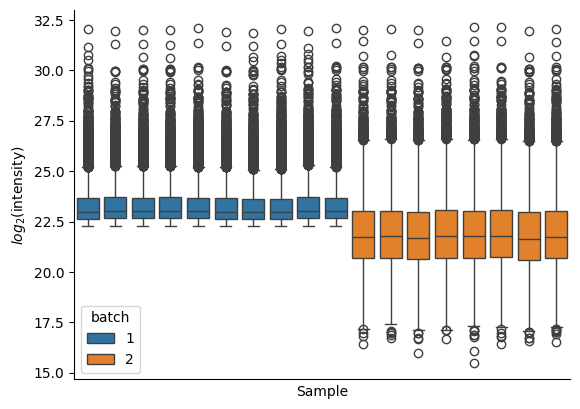

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

quant_matrix = QuantMatrix(
    quantification_file=data_file,
    design_matrix_file=design_matrix,
)

quantified_data = quant_matrix.filter().normalize(method="log2")
plot_df = (
    quantified_data.to_df()
    .set_index("Protein")[design_matrix["sample"]]
    .stack()
    .reset_index()
)

plot_df = plot_df.merge(design_matrix, left_on="level_1", right_on="sample")
plot_df.sort_values("batch", inplace=True)

sns.boxplot(plot_df, x="level_1", y=0, hue="batch", palette="tab10")

sns.despine()
plt.xticks([])
plt.xlabel("Sample")
plt.ylabel(r"$log_2$(intensity)")

plt.savefig("../docs/img/non_corrected_boxes.png", dpi=300)

[WARNING] Mean of empty slice

[WARNING] Degrees of freedom <= 0 for slice.

[WARNING] Mean of empty slice

[WARNING] invalid value encountered in true_divide

[WARNING] divide by zero encountered in true_divide

[WARNING] invalid value encountered in multiply



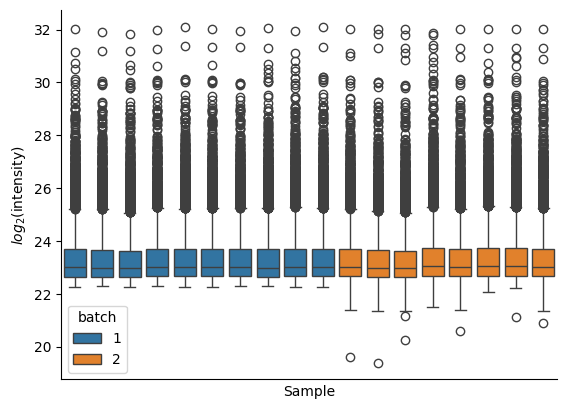

In [38]:
quant_matrix = QuantMatrix(
    quantification_file=data_file,
    design_matrix_file=design_matrix,
)

quantified_data = (
    quant_matrix.filter()
    .normalize(method="log2")
    .correct(method="mean", reference_batch=1)
)

plot_df = (
    quantified_data.to_df()
    .set_index("Protein")[design_matrix["sample"]]
    .stack()
    .reset_index()
)
plot_df = plot_df.merge(design_matrix, left_on="level_1", right_on="sample")
plot_df.sort_values("batch", inplace=True)
sns.boxplot(plot_df, x="level_1", y=0, hue="batch", palette="tab10")
sns.despine()
plt.xticks([])
plt.xlabel("Sample")
plt.ylabel(r"$log_2$(intensity)")

plt.savefig("../docs/img/corrected_boxes.png", dpi=300)

[WARNING] n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



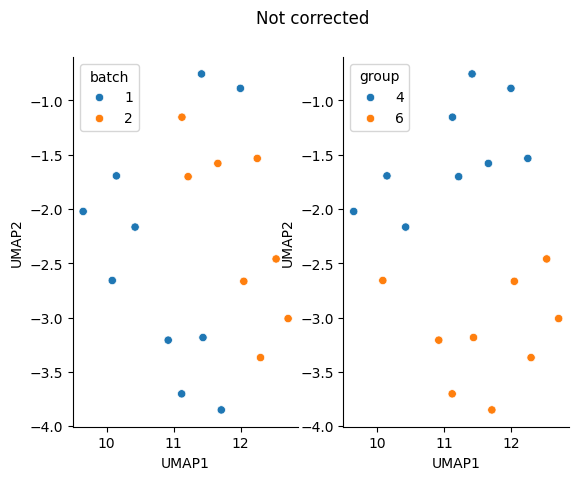

In [39]:
from umap import UMAP

quant_matrix = QuantMatrix(
    quantification_file=data_file,
    design_matrix_file=design_matrix,
)

quantified_data = (
    quant_matrix.filter().normalize(method="log2").impute(method="uniform_percentile")
)

X = pd.DataFrame(quantified_data.quantitative_data.X).fillna(0).T

y = design_matrix["group"]

X_reduced = UMAP(random_state=42).fit_transform(X)

plot_df = pd.DataFrame(X_reduced, columns=["UMAP1", "UMAP2"])
plot_df["group"] = design_matrix["group"]
plot_df["batch"] = design_matrix["batch"]

fig, axs = plt.subplots(1,2)
sns.scatterplot(plot_df, x="UMAP1", y="UMAP2", hue="batch", ax=axs[0], palette="tab10")
sns.scatterplot(plot_df, x="UMAP1", y="UMAP2", hue="group", ax=axs[1], palette="tab10")

plt.suptitle("Not corrected")

for ax in axs.ravel():
    sns.despine(ax=ax)

plt.savefig("../docs/img/non_corrected_umaps.png", dpi=300)


[WARNING] n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



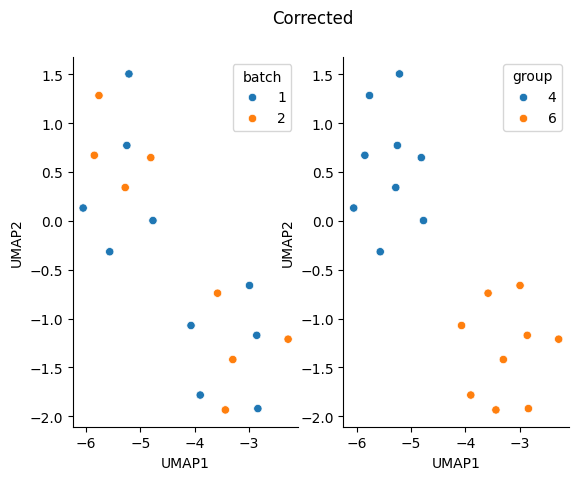

In [40]:
from umap import UMAP

quant_matrix = QuantMatrix(
    quantification_file=data_file,
    design_matrix_file=design_matrix,
)

quantified_data = (
    quant_matrix.filter().impute(method="uniform_percentile").correct(method="mean", reference_batch=1)
)

X = pd.DataFrame(quantified_data.quantitative_data.X).fillna(0).T

y = design_matrix["group"]

X_reduced = UMAP(random_state=42).fit_transform(X)

plot_df = pd.DataFrame(X_reduced, columns=["UMAP1", "UMAP2"])
plot_df["group"] = design_matrix["group"]
plot_df["batch"] = design_matrix["batch"]

fig, axs = plt.subplots(1,2)
sns.scatterplot(plot_df, x="UMAP1", y="UMAP2", hue="batch", ax=axs[0], palette="tab10")
sns.scatterplot(plot_df, x="UMAP1", y="UMAP2", hue="group", ax=axs[1], palette="tab10")

plt.suptitle("Corrected")


for ax in axs.ravel():
    sns.despine(ax=ax)

plt.savefig("../docs/img/corrected_umaps.png", dpi=300)